In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
from torchtext import data
from sklearn.metrics import confusion_matrix,f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import  classification_report

In [ ]:
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
from transformers import BertTokenizer
 
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
len(tokenizer.vocab)

30522

In [ ]:
tokens = tokenizer.tokenize('Hey, whats up man!?')
 
print(tokens)

['hey', ',', 'what', '##s', 'up', 'man', '!', '?']


In [ ]:
indexes = tokenizer.convert_tokens_to_ids(tokens)
indexes

[4931, 1010, 2054, 2015, 2039, 2158, 999, 1029]

In [ ]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token
 
print(init_token,eos_token,pad_token,unk_token)

[CLS] [SEP] [PAD] [UNK]


In [ ]:
init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)
 
print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


In [ ]:
max_input_lengths = tokenizer.max_model_input_sizes["bert-base-uncased"]
print(max_input_lengths)

512


In [ ]:
def tokenize_fn(sentence):
  tokens = tokenizer.tokenize(sentence)
  tokens = tokens[:max_input_lengths-2]
  return tokens

In [ ]:
TEXT = data.Field(tokenize=tokenize_fn,
                  use_vocab=False,
                  batch_first=True,
                  preprocessing=tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx,
                  include_lengths=True)
LABEL = data.LabelField()
fields = [(None,None),('text', TEXT),('label',LABEL), (None,None)]

In [ ]:
train_data, test_data = data.TabularDataset.splits(
                                        path = '/content/drive/MyDrive/data/benchmarking_data',
                                        train = 'train.csv',
                                        test = 'valid.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = True
)

In [ ]:
import random
train_data,valid_data = train_data.split(random_state=random.seed(SEED))

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(vars(train_data.examples[6])['text'])
 
print(tokens)

['what', 'time', 'does', 'k', '##rak', '##en', ':', 'tentacles', 'of', 'the', 'deep', 'play']


In [ ]:
LABEL.build_vocab(train_data)
print(LABEL.vocab.stoi)

defaultdict(None, {'PlayMusic': 0, 'BookRestaurant': 1, 'AddToPlaylist': 2, 'GetWeather': 3, 'SearchScreeningEvent': 4, 'RateBook': 5, 'SearchCreativeWork': 6})


In [ ]:
BATCH_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 
train_dl,valid_dl,test_dl = data.BucketIterator.splits(
    (train_data,valid_data,test_data),
    batch_size=BATCH_SIZE,
    device=device,
    sort_within_batch=True,
    sort_key=lambda x:len(x.text)
)

In [ ]:
from transformers import BertTokenizer, BertModel
 
bert = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
class BertGRU(nn.Module):
  def __init__(self,bert,hidden_dim,output_dim,n_layers,
               bidirectional,dropout):
    super().__init__()
 
    self.bert = bert
 
    embedding_dim = bert.config.to_dict()["hidden_size"]
 
    
    self.gru = nn.GRU(embedding_dim,hidden_dim,num_layers=n_layers,
                        bidirectional=bidirectional,
                        batch_first=True,
                        dropout=0 if n_layers < 2 else dropout)
    
    self.fc = nn.Linear(hidden_dim*2,output_dim)
 
    self.dropout = nn.Dropout(dropout)
 
  def forward(self,text,text_lengths):
    #text = [sent_len,batch_size]
    with torch.no_grad():
      embedded = self.bert(text)[0]
    
    #embedded = [sent_len,batch_size,emb_dim]   
      _, hidden = self.gru(embedded)
        
    #hidden = [n layers * n directions, batch size, emb dim]
 
    hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
 
    #output = [batch size, out dim]
    return self.fc(hidden)

In [ ]:
HIDDEN_DIM = 256
OUTPUT_DIM = len(LABEL.vocab)
N_LAYERS = 2
BIDIRECTIONAL = False
DROPOUT = 0.25
 
model = BertLSTM(bert, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT)
 
#model = BertClassifier(bert,
                    #   DROPOUT,
                     #  OUTPUT_DIM)

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
 
print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 110,668,551 trainable parameters


In [ ]:
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
 
print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 1,186,311 trainable parameters


In [ ]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

lstm.weight_ih_l0
lstm.weight_hh_l0
lstm.bias_ih_l0
lstm.bias_hh_l0
lstm.weight_ih_l1
lstm.weight_hh_l1
lstm.bias_ih_l1
lstm.bias_hh_l1
fc.weight
fc.bias


In [ ]:
import torch.optim as optim
 
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
 
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def accuracy(y_pred,y):
  """
  Returns a accuracy score
  """
  max_preds = y_pred.argmax(dim=1,keepdim=True)
  correct = max_preds.squeeze(1).eq(y)
  return correct.sum()/torch.FloatTensor([y.shape[0]])

In [ ]:
#train the model
def train(model,iterator,optimizer,criterion):
  epoch_loss = 0
  epoch_acc = 0
 
  model.train()
 
  for batch in iterator:
 
    optimizer.zero_grad()
 
    text,text_lengths = batch.text
 
    predictions = model(text,text_lengths)
 
    loss = criterion(predictions,batch.label)
 
    acc = accuracy(predictions,batch.label)
 
    loss.backward()
 
    optimizer.step()
 
    epoch_loss += loss.item()
    epoch_acc += acc.item()
 
  return epoch_loss/len(iterator),epoch_acc/len(iterator)

In [ ]:
def evaluate(model,iterator,criterion):
  epoch_loss = 0
  epoch_acc = 0
 
  model.eval()
 
  with torch.no_grad():
    for batch in iterator:
 
      text,text_lengths = batch.text
 
      predictions = model(text,text_lengths)
 
      loss = criterion(predictions,batch.label)
 
      acc = accuracy(predictions,batch.label)
 
      epoch_loss += loss.item()
      epoch_acc += acc.item()
      
    return epoch_loss/len(iterator),epoch_acc/len(iterator)

In [ ]:
import time
 
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:

N_EPOCHS = 5
 
best_valid_loss = float('inf')
 
for epoch in range(N_EPOCHS):
 
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_dl, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_dl, criterion)
    
    end_time = time.time()
 
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/Models/INTENT/bert-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 9m 12s
	Train Loss: 1.447 | Train Acc: 63.34%
	 Val. Loss: 1.026 |  Val. Acc: 84.09%
Epoch: 02 | Epoch Time: 9m 12s
	Train Loss: 0.932 | Train Acc: 81.11%
	 Val. Loss: 0.726 |  Val. Acc: 86.54%
Epoch: 03 | Epoch Time: 9m 7s
	Train Loss: 0.738 | Train Acc: 83.33%
	 Val. Loss: 0.586 |  Val. Acc: 87.72%
Epoch: 04 | Epoch Time: 9m 9s
	Train Loss: 0.629 | Train Acc: 84.50%
	 Val. Loss: 0.507 |  Val. Acc: 88.53%
Epoch: 05 | Epoch Time: 9m 10s
	Train Loss: 0.574 | Train Acc: 84.95%
	 Val. Loss: 0.454 |  Val. Acc: 89.09%


In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Models/INTENT/bert-model.pt"))

test_loss, test_acc = evaluate(model,test_dl,criterion)

In [ ]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.660 | Test Acc: 83.20%


In [ ]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]
 
    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
 
    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    B = (C/C.sum(axis=0))
    labels = [1,2,3,4,5,6,7,8,9]

In [ ]:
def get_predictions(model,iterator):
  y_pred = []
  y_true = []

  model.eval()
  with torch.no_grad():
    for batch in iterator:

      text,text_lengths = batch.text

      predictions = model(text,text_lengths)

      y_pred.extend(torch.argmax(predictions,axis=-1).tolist())
      y_true.extend(batch.label.tolist())

  return y_pred,y_true

In [ ]:
y_pred,y_true = get_predictions(model,test_dl)

-------------------- Confusion matrix --------------------


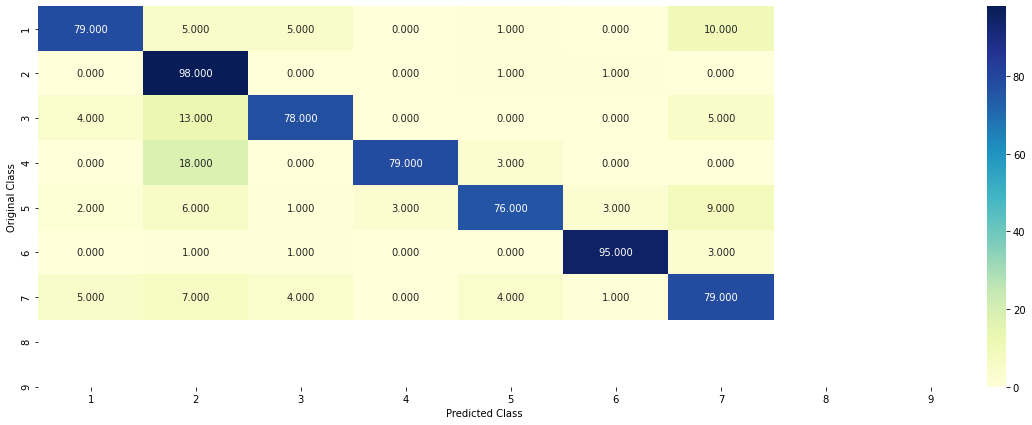

-------------------- Precision matrix (Columm Sum=1) --------------------


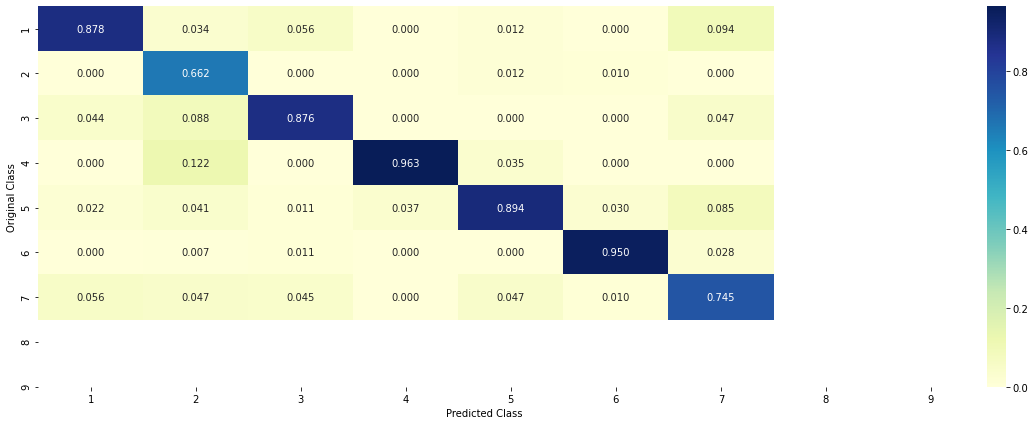

-------------------- Recall matrix (Row sum=1) --------------------


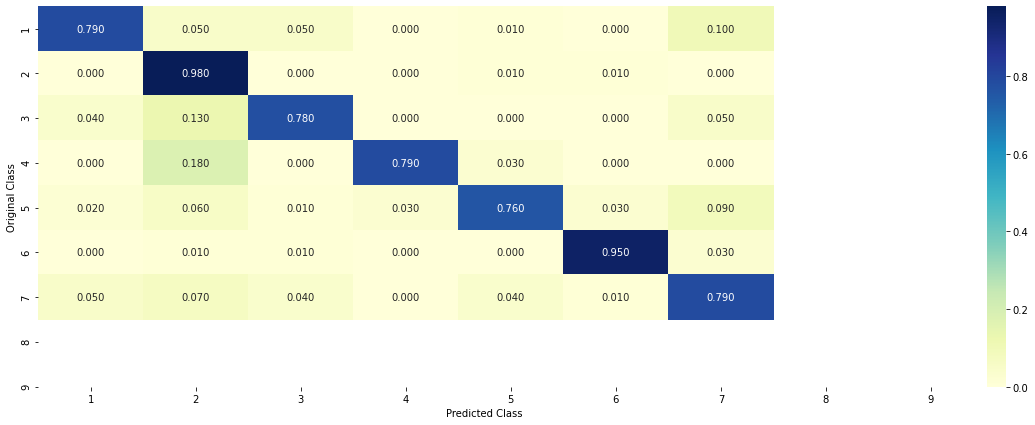

In [ ]:
plot_confusion_matrix(y_true,y_pred)

In [ ]:
print('Classification Report:')
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       100
           1       0.66      0.98      0.79       100
           2       0.88      0.78      0.83       100
           3       0.96      0.79      0.87       100
           4       0.89      0.76      0.82       100
           5       0.95      0.95      0.95       100
           6       0.75      0.79      0.77       100

    accuracy                           0.83       700
   macro avg       0.85      0.83      0.84       700
weighted avg       0.85      0.83      0.84       700

